*Теоретический материал:* https://youtu.be/TGO-YPrfs1A

## Как один из вариантов применения генетического алгоритма рассмотрим симуляцию посадки ракеты из библиотеки OpenAI. 

Для начала необходимо установить окружение.

# Настройка окружения Colab

*Разбор данного раздела:* https://youtu.be/4zlh84tykx8?t=360

Движок box2d, на котором будет происходить симуляция посадки корабля рассчитан на работу, в первую очередь, в консоли, поэтому необходимо предварительно настроить среду 

In [ ]:
# Будем обращаться к линукс-ядру напрямую с помощью команд на "!"
# Будем устанавливать окружение из пакета Stable Baseline для OpenAI (для того, чтобы можно было использовать движок в колабе)
# Код, представленный в документации разработчика
!apt install swig cmake libopenmpi-dev zlib1g-dev # cmake - сборка - аналог GNU Make, но с другим синтаксисом, libopenmpi-dev распределённые вычисления в кластере для дебиан, zlib1g-dev - сжатие траффика
!pip install stable-baselines==2.5.1 box2d box2d-kengz # устанавливаем непосредственно сам stable baseline и движок box2d

# если убрать " > /dev/null 2>&1" то работа сервера будет выведена на экран, а этой командой перемещаем все в фоновый режим
!pip install gym pyvirtualdisplay > /dev/null 2>&1 # установка пакета для рендера видео
!pip install xvfbwrapper # установка обертки для пакета, который позволит воспроизводить видео в ячейке колаба  
!apt-get update # обновляем все пакеты до новейшей версии, чтобы все пакеты "подружились"
!sudo apt-get install xvfb # установка удаленного сервера, благодаря которому видео будет воспроизводиться в ячейке колаба
!apt-get install xdpyinfo # пакет для вывода процессов, происходящих на сервере

Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
libopenmpi-dev is already the newest version (2.1.1-8).
swig is already the newest version (3.0.12-1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 63 not upgraded.
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http:

# Импорт библиотек



In [ ]:
import gym # здесь лежат все модели для 
from gym import logger as gymlogger # загрузим библиотеку для изменения параметра вывода ошибок
from gym.wrappers import Monitor # библиотека для обертки видео из хранилища в ячейку
gymlogger.set_level(40) # для правильного отображения ошибок
import numpy as np # библиотека массивов numpy
import random # библиотека для генерации случайных значений
import matplotlib # библиотека для визуализации процессов
import matplotlib.pyplot as plt # библиотека для построения графика
%matplotlib inline
import glob # расширение для использования Unix обозначений при задании пути к файлу
import io # библиотека для работы с потоковыми данными
import base64 # расширение для преобразования в формат base64 (универсальный формат хранения сырых изображений в виде набора электрических сигналов)
from IPython.display import HTML # библиотека для кодирования в код HTML
import time # библиотека для расчета времени обучения

from IPython import display as ipythondisplay # для работы с "сырым" форматом (набор сигналов, а не пиксели)
from pyvirtualdisplay import Display # для создания окна дисплея


In [ ]:
# Создаем объект дисплей, таким образом, симуляцию можно будет наблюдать в колабе
display = Display(visible=0, size=(1400, 900))
display.start()

## LunarLander-v2

*Разбор данного раздела:* https://youtu.be/4zlh84tykx8?t=400


Задача данной симуляции заключается в посадке корабля на посадочную площадку. 

Оценивается то, *куда* вы его посадите и *как*. 

Для управления кораблем мы используем три двигателя: центральный, с левой ориентацией и правой ориентацией.

В итоге, на каждое из наших действий - **action** - среда выдает наблюдение - observation.

**Observation** - вектор размерности (8,), где первые шесть цифр - отклик самого физического движка (x-координата, y-координата, x-скорость, y-скорость, угол ракеты, укгловая скорость, факт приземления на левую ногу, факт приземления на правую ногу), а последние две цифры - координаты приземления. Т.е. пока ракета не приземлилась, последние два числа будут (0,0). Если на посадочной площадке, то (1,1). Если с какой-то из сторон, то (1,0) или (0,1) соответственно.

Как было сказано ранее, важно то, *как* мы приземляемся. 
За это отвечает награда - **reward**. Баллы могут складываться и вычитаться в зависимости от действия. Награда за переход от верхней части экрана к посадочной площадке и нулевой скорости составляет около 100..140 баллов. Если включен основной двигатель, то за каждый кадр (одно действие) -0,3 балла. Если ракета отходит от посадочной площадки, то присвоенная ранее награда за вычитается. При этом топливо бесконечно и эпизод заканчивается в момент приземления (либо ракета падает либо мягко приземляется). Допускается посадка вне посадочной площадки. За каждый контакт ноги с поверхностью +10 баллов. За падение (резкое приземление) -100 баллов, за мягкое приземление +100 баллов. 
В сумме решеная задача (за переход от верхней части экрана к посадочной площадке+мягкое приземление) дает 200..250 баллов. 

**Резюме**: на вход среды подаем одно из действий:

* 0 - ничего не делать 
* 1 - запустить двигатель с левой ориентацией
* 2 - запустить двигатель по центру
* 3 - запустить двигатель с правой ориентацией

на выходе получаем вектор observation и reward за текущее действие.
Эпизод будет идти до момента приземления.

**Цель**: максимизировать награду


![Lunar Lander](https://cdn-images-1.medium.com/max/960/1*f4VZPKOI0PYNWiwt0la0Rg.gif)




In [ ]:
'''

Функция, позволяющая записывать видео того,
что происходит в окружении и отображать это в колабе

'''

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
# Запускаем среду
env = gym.make('LunarLander-v2')

In [ ]:
numBots = 100
popul = [] # здесь будет лежать популяция

for i in range(numBots):  
  bot = np.random.random((8,4))
  popul.append(bot)

In [ ]:
env = wrap_env(env) # оборачиваем наше окружения для записи видео
env.seed(0) # симуляция одного и того же окружения
observation = env.reset() # обнуляем вектор наблюдения
i=0
action = 0
while True:

    env.render() # Рендер окружения
    # В качестве действия будем подавать значения нашего лучшего бота
    observation,reward,done,_ = env.step(action) # остлеживаем все параметры для подсчета функции значения
    result = np.dot(observation,popul[np.random.randint(0, numBots-1)])
    action = np.argmax(result)
    if done: 
      break;
            
env.close()
show_video()

# Генетические алгоритмы

*Разбор данного раздела:* https://youtu.be/4zlh84tykx8?t=1069


In [ ]:
'''
    Функция получения выжившей популяции
        Входные параметры:
        - popul - наша популяция
        - val - текущие значения
        - nsurv - количество выживших
        - reverse - указываем требуемую операцию поиска результата: максимизация или минимизация
'''
def getSurvPopul(
        popul,
        val,
        nsurv,
        reverse
        ):
    newpopul = [] # Двумерный массив для новой популяции

    sval= sorted(val, reverse=reverse) # Сортируем зачения в val в зависимости от параметра reverse
    for i in range(nsurv): # Проходимся по циклу nsurv-раз (в итоге в newpopul запишется nsurv-лучших показателей)
        index = val.index(sval[i]) # Получаем индекс i-того элемента sval в исходном массиве val
        newpopul.append(popul[index]) # В новую папуляцию добавляем элемент из текущей популяции с найденным индексом
    return newpopul, sval # Возвращаем новую популяцию (из nsurv элементов) и сортированный список

'''
    Функция получения родителей
        Входные параметры:
        - curr_popul - текущая популяция
        - nsurv - количество выживших
'''
def getParents(
        curr_popul,
        nsurv
        ):   
    indexp1 = random.randint(0, nsurv - 1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    indexp2 = random.randint(0, nsurv - 1) # Случайный индекс второго родителя в диапазоне от 0 до nsurv - 1    
    botp1 = curr_popul[indexp1] # Получаем первого бота-родителя по indexp1
    botp2 = curr_popul[indexp2] # Получаем второго бота-родителя по indexp2 
   
    return botp1,botp2 # Возвращаем обоих полученных ботов

'''
    Функция смешивания (кроссинговера) двух родителей
        Входные параметры:
        - botp1 - первый бот-родитель
        - botp2 - второй бот-родитель
        - j - номер компонента бота
'''

def crossPointFrom2Parents(
        botp1,
        botp2, 
        j
        ):
    pindex = np.random.random() # Получаем случайное число в диапазоне от 0 до 1
    
     #Если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
    if pindex < 0.5:
        x = botp1[j]
    else:
        x = botp2[j]
    return x # Возвращаем значние бота

    

'''
    Функция расчета вознаграждения за эпизод
        Входные параметры:
        - popul - популяция ботов
'''

def countValue(
    popul
    ):
  
  action=0  # генерируем первое  действие случайным из пространства действий
                                     # 0 - ничего не делать 
                                     # 1 - запустить двигатель с левой ориентацией
                                     # 2 - запустить двигатель по центру
                                     # 3 - запустить двигатель с правой ориентацией

  reward_list=[] # здесь будет сумма вознаграждений для каждого эпизода

  for bot in popul: # проходимся по каждому боту в популяции
    env.seed(0)  # При инициализации среда генерируется случайным образом каждый раз новая,
                 # поэтому ограничим интервал генерации - т.е. будем использовать только одну конкретную среду
    env.reset() # И обновлять окружение
    i=0 
    tmp=0
    done=False
    while done!=True:
      observation,reward,done,_ = env.step(action) # остлеживаем все параметры для подсчета функции значения
      result = np.dot(observation,bot) # матрично перемножаем бота и вектор наблюдения для предсказания следующего движения
      action = np.argmax(result) # максимальный аргумент - наше движение
      tmp+=reward
    reward_list.append(tmp) # Функция, по которой будет вычисляться "успех текущей симуляции"
    
  return reward_list  

Эволюция ботов на одной среде


0 2.099313735961914   [8.826844972545743, -65.46665659430853, -74.59538413180695]
1 0.3632485866546631   [231.54975431882406, 13.493991656416952, -29.111110929507518]
2 0.40059542655944824   [8.524390647761479, 6.484384748731884, -17.61838987043079]
3 0.45122265815734863   [232.13152056433333, 29.456030779160443, 13.444926072065982]
4 0.5482196807861328   [16.657106178059806, 6.484384748731884, -0.00018148325372635554]
5 0.8644654750823975   [16.657106178059806, 10.287754615143058, 3.7836850922774374]
6 0.7185986042022705   [251.29689825645883, 194.14613935843917, 10.287754615143058]
7 2.1596548557281494   [18.090417982683846, 8.807461776136464, 4.4577534923936355]
8 4.059504270553589   [28.037835647189638, 24.55464555960836, 22.899189770325364]
9 2.704796552658081   [156.1889179416657, 20.384190225299776, 20.146307421479094]
10 1.6975007057189941   [203.77562910647117, 194.02429362146017, 185.52538660157973]
11 2.7278201580047607   [225.6489502224174, 211.80614296746842, 194.819687725

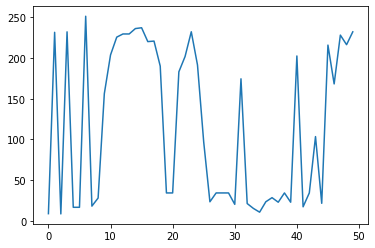

In [ ]:
total=[] # Для построения графика
n = 40 # популяция
nsurv = 20 # количество выживших
nnew = n-nsurv # количество новых
epohs = 50 # количество эпох
mut = 0.2 # коэфициент мутаций
curr_time = time.time()

for it in range(epohs): # создали список списков всех значений по эпохам
  val = countValue(popul) # считаем успех каждого из ботов
  newpopul, sval = getSurvPopul(popul, val, nsurv, 1) # получили популяцию выживших, нас интересует бот с максимальным успехом, поэтому reverse = 1
  print(it, time.time() - curr_time, " ", sval[0:3]) # Выводим время на операцию, среднее значение и 20 лучших ботов  
  total.append(sval[0]) # заносим самого лучшего бота в список для построения графика эволюции
  curr_time = time.time() # Обновляем текущее время

  # проходимся по новой популяции
  for k in range(nnew):

    # вытаскиваем новых родителей
    botp1, botp2 = getParents(newpopul, nsurv) 
    newbot = [] # здесь будет новый бот

    for j in range(len(botp1)): # боты-родители одинаковой длины, будем проходиться по каждому элементу родителя
      x = crossPointFrom2Parents(botp1, botp2,j) # скрещиваем
      for t in range(4):
        if random.random()<mut:
          x[t] += random.random()*1e-1
      newbot.append(x) # закидываем элемент в бота
    newpopul.append(newbot) # добавляем бота
  popul = newpopul # вывести список на эпоху
  popul = np.array(popul) # для того, чтобы можно было легко вытащить индексы условием, преобразуем в numpy массив
plt.plot(total)
print(np.mean(total)) 

In [ ]:
val = countValue(popul) # считаем успех каждого из ботов
newpopul, sval = getSurvPopul(popul, val, nsurv, 1) # получили популяцию выживших, нас интересует бот с максимальным успехом, поэтому reverse = 1

In [ ]:
env = wrap_env(env) # оборачиваем наше окружения для записи видео
env.seed(0) # симуляция одного и того же окружения
observation = env.reset() # обнуляем вектор наблюдения
i=0
action = 0
while True:

    env.render() # Рендер окружения
    # В качестве действия будем подавать значения нашего лучшего бота
    observation,reward,done,_ = env.step(action) # остлеживаем все параметры для подсчета функции значения
    result = np.dot(observation,newpopul[1])
    action = np.argmax(result)
    if done: 
      break;
            
env.close()
show_video()

In [ ]:
reward

100

Тот же алгоритм на случайном окружении

In [ ]:
env = wrap_env(env) # оборачиваем наше окружения для записи видео
# env.seed(0) 
observation = env.reset() # обнуляем вектор наблюдения
i=0
action = 0
while True:

    env.render() # Рендер окружения
    # В качестве действия будем подавать значения нашего лучшего бота
    observation,reward,done,_ = env.step(action) # остлеживаем все параметры для подсчета функции значения
    result = np.dot(observation,popul[0])
    action = np.argmax(result)
    if done: 
      break;
            
env.close()
show_video()

In [ ]:
reward

-100

Эволюция ботов на случайно сгенерированных средах


In [ ]:
def countValue(
    popul
    ):
  
  action=0  # генерируем первое  действие случайным из пространства действий
                                     # 0 - ничего не делать 
                                     # 1 - запустить двигатель с левой ориентацией
                                     # 2 - запустить двигатель по центру
                                     # 3 - запустить двигатель с правой ориентацией

  reward_list=[] # здесь будет сумма вознаграждений для каждого эпизода

  for bot in popul: # проходимся по каждому боту в популяции
   # env.seed(0)  # При инициализации среда генерируется случайным образом каждый раз новая,
                 # поэтому ограничим интервал генерации - т.е. будем использовать только одну конкретную среду
    env.reset() # И обновлять окружение
    i=0 
    tmp=0
    done=False
    while done!=True:
      observation,reward,done,_ = env.step(action) # остлеживаем все параметры для подсчета функции значения
      result = np.dot(observation,bot) # матрично перемножаем бота и вектор наблюдения для предсказания следующего движения
      action = np.argmax(result) # максимальный аргумент - наше движение
      tmp+=reward
    reward_list.append(tmp) # Функция, по которой будет вычисляться "успех текущей симуляции"
    
  return reward_list  

0 3.443910598754883   [266.4419303064849, 259.44560339090583, -4.026876983251228]
1 12.183714866638184   [250.39616603872255, 231.8231111079706, 199.603030662302]
2 7.423816204071045   [209.14425509157957, 58.93772228195704, 28.124089422421804]
3 16.405479192733765   [156.80002134406286, 94.76075884917994, 45.17386269294077]
4 10.542782068252563   [234.50842289412907, 219.14830407091114, 52.69631089091672]
5 7.760791540145874   [216.42064029158087, 192.56179788175962, 138.46691519550146]
6 5.138389587402344   [41.38924937331737, 27.720316927567424, 13.245866352642125]
7 5.434581756591797   [173.22375798413105, 69.9072793613737, 57.014063780371345]
8 9.65330719947815   [258.18097382285333, 189.08139069620535, 178.45587636255655]
9 13.953498840332031   [79.46736424275099, 45.61703376537366, 24.84017632985155]
10 7.250453233718872   [269.0096066232309, 186.5126198057307, 128.25115398283668]
11 10.54481291770935   [255.48253513400928, 229.10574872504736, 214.7212550747452]
12 14.6209547519

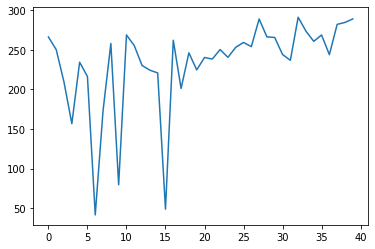

In [ ]:
total=[] # Для построения графика
n = 100 # популяция
nsurv = 20 # количество выживших
nnew = n-nsurv # количество новых
epohs = 40 # количество эпох
mut = 0.3 # коэфициент мутаций
curr_time = time.time()

for it in range(epohs): # создали список списков всех значений по эпохам
  val = countValue(popul) # считаем успех каждого из ботов
  newpopul, sval = getSurvPopul(popul, val, nsurv,1) # получили популяцию выживших, нас интересует бот с максимальным успехом, поэтому reverse = 1
  print(it, time.time() - curr_time, " ", sval[0:3]) # Выводим время на операцию, среднее значение и 20 лучших ботов  
  total.append(sval[0]) # заносим самого лучшего бота в список для построения графика эволюции
  curr_time = time.time() # Обновляем текущее время

 # проходимся по новой популяции
  for k in range(nnew):

    # вытаскиваем новых родителей
    botp1, botp2 = getParents(newpopul, nsurv) 
    newbot = [] # здесь будет новый бот

    for j in range(len(botp1)): # боты-родители одинаковой длины, будем проходиться по каждому элементу родителя
      x = crossPointFrom2Parents(botp1, botp2,j) # скрещиваем
      for t in range(4):
        if random.random()<mut:
          x[t] += random.random()*1e-1
      newbot.append(x) # закидываем элемент в бота
    newpopul.append(newbot) # добавляем бота
  popul = newpopul # вывести список на эпоху
  popul = np.array(popul) # для того, чтобы можно было легко вытащить индексы условием, преобразуем в numpy массив
plt.plot(total)
print(np.mean(total)) 

In [ ]:
env = wrap_env(env) # оборачиваем наше окружения для записи видео
observation = env.reset() # обнуляем вектор наблюдения
i=0
action = 0
while True:

    env.render() # Рендер окружения
    # В качестве действия будем подавать значения нашего лучшего бота
    observation,reward,done,_ = env.step(action) # остлеживаем все параметры для подсчета функции значения
    result = np.dot(observation,popul[0])
    action = np.argmax(result)
    if done: 
      break;
            
env.close()
show_video()

In [ ]:
env = wrap_env(env) # оборачиваем наше окружения для записи видео
observation = env.reset() # обнуляем вектор наблюдения
i=0
action = 0
while True:

    env.render() # Рендер окружения
    # В качестве действия будем подавать значения нашего лучшего бота
    observation,reward,done,_ = env.step(action) # остлеживаем все параметры для подсчета функции значения
    result = np.dot(observation,popul[0])
    action = np.argmax(result)
    if done: 
      break;
            
env.close()
show_video()

In [ ]:
env = wrap_env(env) # оборачиваем наше окружения для записи видео
observation = env.reset() # обнуляем вектор наблюдения
i=0
action = 0
while True:

    env.render() # Рендер окружения
    # В качестве действия будем подавать значения нашего лучшего бота
    observation,reward,done,_ = env.step(action) # остлеживаем все параметры для подсчета функции значения
    result = np.dot(observation,popul[0])
    action = np.argmax(result)
    if done: 
      break;
            
env.close()
show_video()